In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from PIL import Image
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers

from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)

2022-05-16 10:02:17.902622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 10:02:17.902664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_dir = 'input//DATASET/TRAIN' #directory with training images
test_dir = 'input/DATASET/TEST' #directory with testing images

In [3]:
train_datagen = ImageDataGenerator(width_shift_range= 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,               #normalize
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,               # Normalize
                                 validation_split = 0.2)

In [4]:
train_generator =  train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 16,
                                                    subset = 'training')
validation_generator  = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  subset = 'validation')

Found 874 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


In [5]:
# clear models and parameters stored in memory
tf.keras.backend.clear_session()

In [6]:
# from lesson 8 and 9 (mostly 9)

# Define architecture, 784x256x128x10 (input x hidden layer1 x hidden layer2 x output layer)
model = Sequential()
# first set of layers CONV => RELU => MAXPOOL
model.add(Conv2D(64, (3,3),                          # 64 = number of kernels
                 padding = "same",
                 input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2),             # the size of the pool 
                       strides = (2,2,)))

# second set of layers CONV => RELU => MAXPOOL
model.add(Conv2D(128, (5,5),
                 padding = "same")) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2),
                       strides = (2,2)))

# third set of layers
model.add(Conv2D(128, (5,5),
                 padding = "same")) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2),
                       strides = (2,2)))

# FC => RELU
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(5))
model.add(Activation("softmax"))


2022-05-16 10:02:25.370335: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-16 10:02:25.370413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (j-71137-job-0): /proc/driver/nvidia/version does not exist
2022-05-16 10:02:25.371029: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     204928    
                                                                 
 activation_1 (Activation)   (None, 112, 112, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

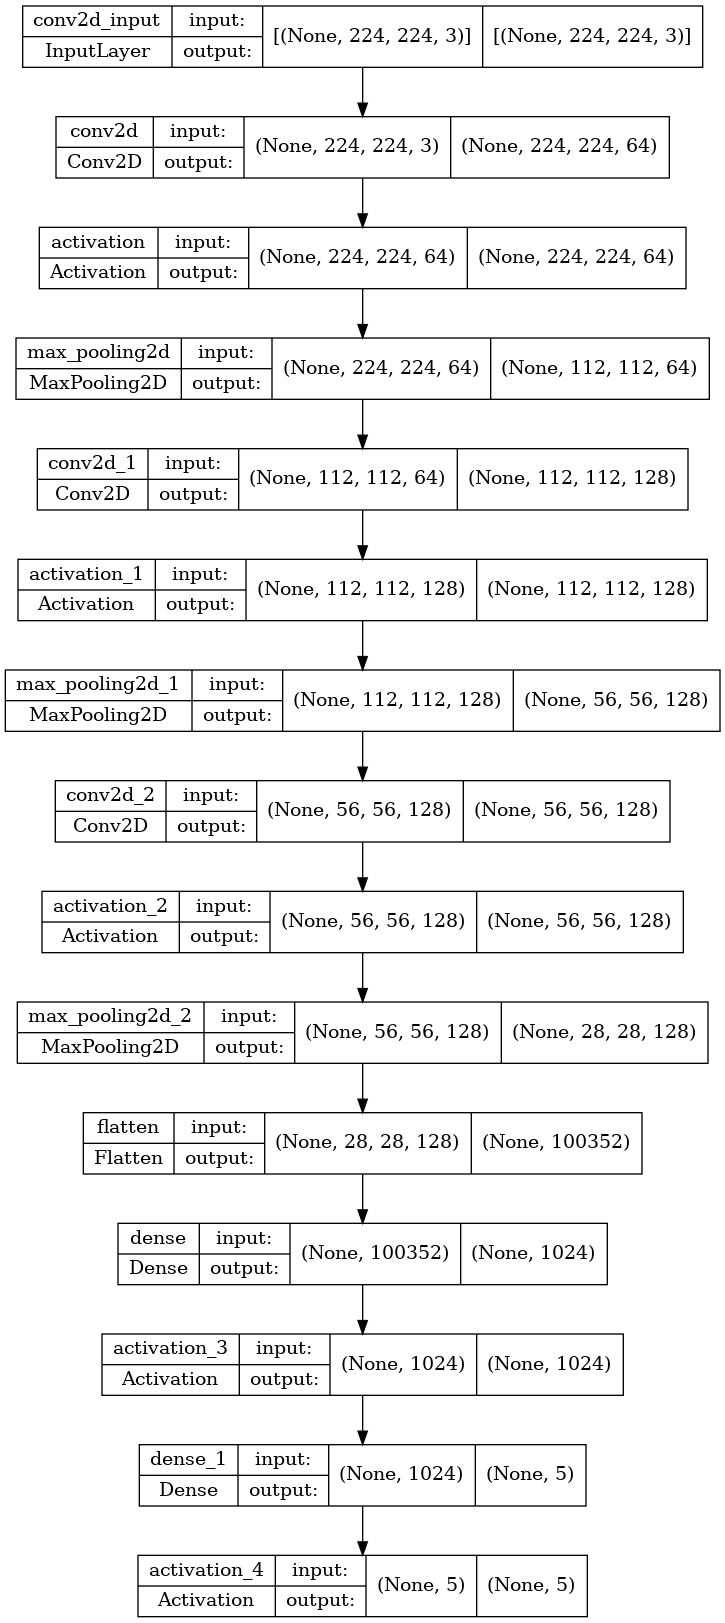

In [8]:
plot_model(model, to_file='output/sequential_model.png', show_shapes = True, show_layer_names = True)

In [9]:
# Define the gradient descent
#sgd = SGD(0.01)
optimizer = Adam(learning_rate=0.001)

# compile model
model.compile(loss = "categorical_crossentropy",
             optimizer = optimizer,
             metrics = ["accuracy"])



In [10]:
# DET HER SKAL VÆRE MED
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=3)

Epoch 1/3
55/55 [==============================] - 102s 2s/step - loss: 1.5748 - accuracy: 0.2780 - val_loss: 1.4472 - val_accuracy: 0.4239
Epoch 2/3
55/55 [==============================] - 100s 2s/step - loss: 1.4077 - accuracy: 0.4256 - val_loss: 1.1842 - val_accuracy: 0.5543
Epoch 3/3
55/55 [==============================] - 100s 2s/step - loss: 1.3430 - accuracy: 0.4371 - val_loss: 1.0295 - val_accuracy: 0.5870


In [13]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    # create canvas
    plt.figure(figsize=(12,6))
    # create subplot, 1 row, 2 colomns and use the first image
    plt.subplot(1,2,1)
    # take training loss from history and plot with each depth from 0 to 10
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    # and take validation loss, validation plot is going to be visualised as pots (linestyle)
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # tight layout
    plt.tight_layout()
    # adding legend
    plt.legend()

    # 1 row, 2 columns, use the second image 
    plt.subplot(1,2,2)
    # accuracy instead of loss
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    # save model
    plt.savefig(os.path.join("output", "trained_model.png"))


ValueError: x and y must have same first dimension, but have shapes (20,) and (3,)

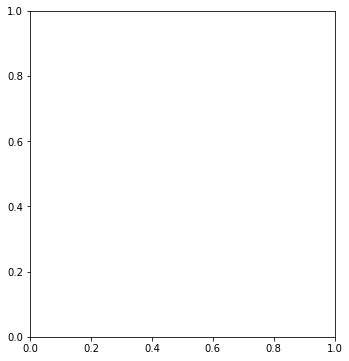

In [14]:
plot_history(history, 20)

In [79]:
# Final evaluation of the model
val_scores = model.evaluate(validation_generator, verbose=1)

print(("The loss score of the validation dataset {val_scores[0]}") \
      .format(val_scores = val_scores))

print(("The accuracy score of the validation dataset {val_scores[1]}") \
      .format(val_scores = val_scores))

3/3 [==============================] - 3s 931ms/step - loss: 0.3535 - accuracy: 0.8913
The loss score of the validation dataset 0.3534677028656006
The accuracy score of the validation dataset 0.8913043737411499


In [80]:
# Final evaluation of the model
train_scores = model.evaluate(train_generator, verbose=1)

print(("The loss score of the train dataset {train_scores[0]}") \
      .format(train_scores = train_scores))

print(("The accuracy score of the train dataset {train_scores[1]}") \
      .format(train_scores = train_scores))

11/55 [=====>........................] - ETA: 16s - loss: 0.1650 - accuracy: 0.9489

/opt/conda/lib/python3.9/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 [==============================] - 20s 364ms/step - loss: 0.1708 - accuracy: 0.9517
The loss score of the train dataset 0.17076388001441956
The accuracy score of the train dataset 0.9516685605049133


In [88]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

3/3 [==============================] - 3s 1s/step - loss: 0.3535 - accuracy: 0.8913
final train accuracy = 93.90 , validation accuracy = 89.13


### Make classification report

In [113]:
# setting decision boundary to 0.5
predictions = (model.predict(train_generator) > 0.5).astype("int32")
#predictions = [labels]

print(predictions)

/opt/conda/lib/python3.9/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]


In [109]:
from sklearn.metrics import (confusion_matrix, 
                            classification_report)

# confusion matrix and classification report
# define labels
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
    
report = classification_report(train_generator, predictions)
# print report
print(report)

ValueError: Found input variables with inconsistent numbers of samples: [55, 869]

### Logistic Regression Classifier

In [110]:

import cv2
import matplotlib.pyplot as plt
import utils.classifier_utils as img 
from utils.imutils import jimshow

import os
import sys
sys.path.append(os.path.join("..", "..", "CDS-VIS"))

# Import teaching utils
import numpy as np
import utils.classifier_utils as clf_util


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [155]:
path = os.path.join("input", "DATASET", "TRAIN", "plank", "00000137.jpg")
test_image = cv2.imread(path)

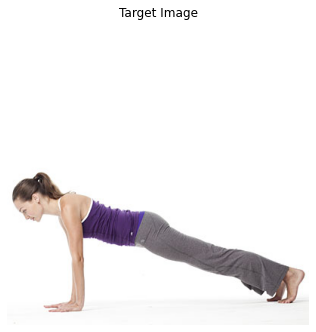

In [156]:
jimshow(test_image, "Target Image")

In [129]:
display = tf.keras.utils.image_dataset_from_directory(train_dir)

class_names = display.class_names

Found 1084 files belonging to 5 classes.


Corrupt JPEG data: premature end of data segment


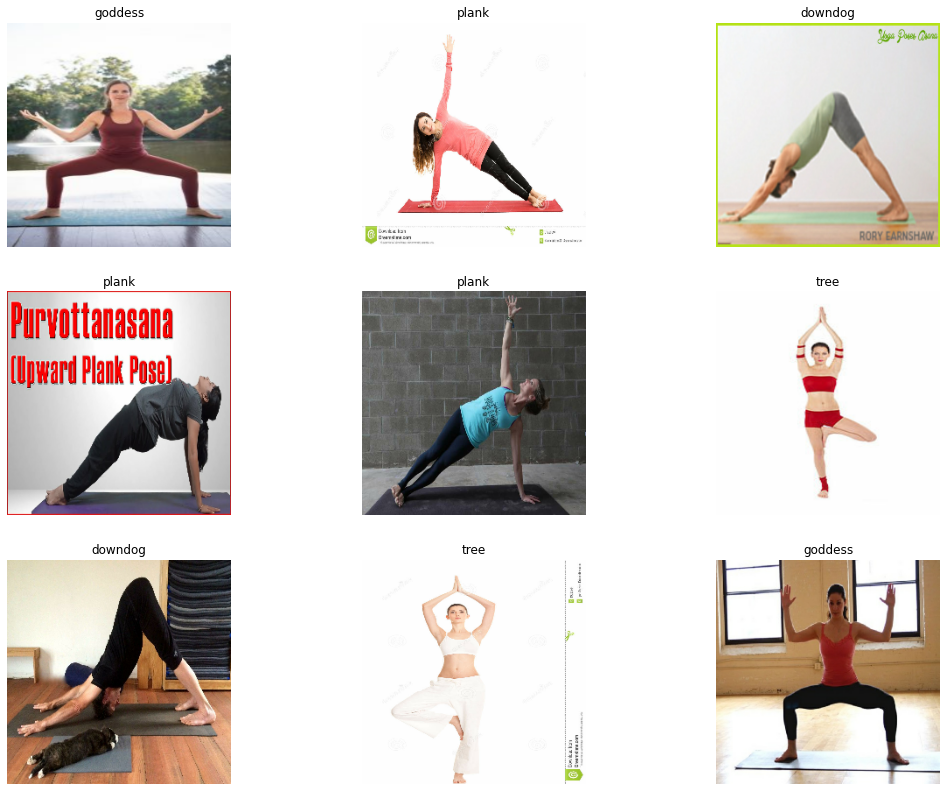

In [160]:
# display 25 images from the training dataset.
plt.figure(figsize=(18,14))
for images, labels in display.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")